# Part 1

In [2]:
from import_data import *
from constants import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# set up parameters based on A4 paper
plt.rcParams.update({
    "savefig.dpi": 300,
    "font.size": 10,  # Font size for text (like in the report)
    # "axes.labelsize": 12,  # Font size for x-axis labels
})

In [3]:
# helper function
def fig_size(x_ratio=1.0, y_ratio=1.0):
    """
    Assuming an A4 paper size, this function returns a tuple
    representing the figure size in inches.
    parameters:
    x_ratio: float, ratio of the width relative to A4 width
    y_ratio: float, ratio of the height relative to A4 height
    """
    A4_WIDTH = 6.202  # A4 paper text width in inches
    A4_HEIGHT = 9.3562  # A4 paper text height in inches
    if x_ratio <= 0 or y_ratio <= 0:
        raise ValueError("Ratios must be positive numbers.")
    return (A4_WIDTH * x_ratio, A4_HEIGHT * y_ratio)


Verify dataset and constants loaded

In [4]:
print("Dataset Name:", DATASET_NAME)
print(len(df_train), 'train samples')
print(len(df_test), 'test samples')

Dataset Name: FD001
20631 train samples
13096 test samples


## Part 1.1:
### Visualize the lifetime data of FD001. Which distribution do you think will provide a good fit? Why? (2 points)
Answer: See the code and the plot below. It is important to note that the test and training data don't seem to have the same distribution. We think a Weibull distribution would be a good fit (or at least a good start), as it is very flexible and it can take many shapes

Example: Engine 1 last cycle: 287


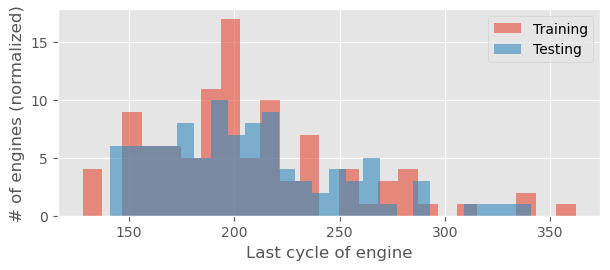

In [5]:
# First group by the engine(id) and find the last cycle
df_train_grouped = df_train.groupby('engine')
df_train_last_cycle = df_train_grouped.max()['cycle']
print(f"Example: Engine 1 last cycle: {df_train_last_cycle[2]}") # example output
df_test_grouped = df_test.groupby('engine')
df_test_last_cycle = df_test_grouped.max()['cycle'].to_numpy()
df_labels = pd.read_csv('Data/RUL_FD001.txt', header=None).to_numpy().flatten()


# Second visualize the distribution of the last cycle
fig, ax = plt.subplots(1, 1, figsize=fig_size(1, 0.3))
ax.hist(df_train_last_cycle, histtype="stepfilled", label="Training", bins=25, alpha=0.6, zorder=2, density=False)
ax.hist(df_test_last_cycle+df_labels, histtype="stepfilled", label="Testing", bins=25, alpha=0.6, zorder=2, density=False)
ax.set_xlabel("Last cycle of engine")
ax.set_ylabel("# of engines (normalized)")

plt.legend()
plt.tight_layout()
plt.show()
fig.savefig("Output/last_cycle_distribution.png")

## Part 1.2
### Fit all distributions available in the reliability package to the data. Which distribution(s) provide the best fit? Is this in line with your expectation?
Answer: See the code and plot below. It appears that a Weibull_2P distribution provided the best fit. Visually: If we look at the probability plot, we see that the Weibull_2P distribution still does not fit the data perfectly though. Likelihood metrics: we see that "Weibull_Mixture" has the highest Log-Likelihood, while "Weibull_2P" has the loweest AIC and BIC values. Expectation: Given that the data does not seem to follow a perfect normal distribution, we expected that a Weibull distribution would provide a good fit. This is in line with our expectation.

c:\Users\sahto\miniconda3\envs\aemntc\Lib\site-packages\reliability\Fitters.py:440: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 100/0 (0% right censored) 

   Distribution   Alpha    Beta   Gamma Alpha 1  Beta 1 Alpha 2  Beta 2 Proportion 1 DS      Mu    Sigma     Lambda  Log-likelihood    AICc     BIC       AD optimizer
     Weibull_2P 147.413 2.66065                                                                                            -537.838  1079.8 1084.89 0.663869       TNC
      Normal_2P                                                                          130.96  53.3248                   -539.534 1083.19 1088.28 0.570222       TNC
     Weibull_3P 136.411 2.43025  9.9644                                                                                    -537.712 1081.67 1089.24 0.789635       TNC
     Weibull_DS 147.413 2.66065                                                       1                                    -537.838 1081.93 1089.49 0.663869       TNC
       Gamma_2P 25.5419 5.12726                             

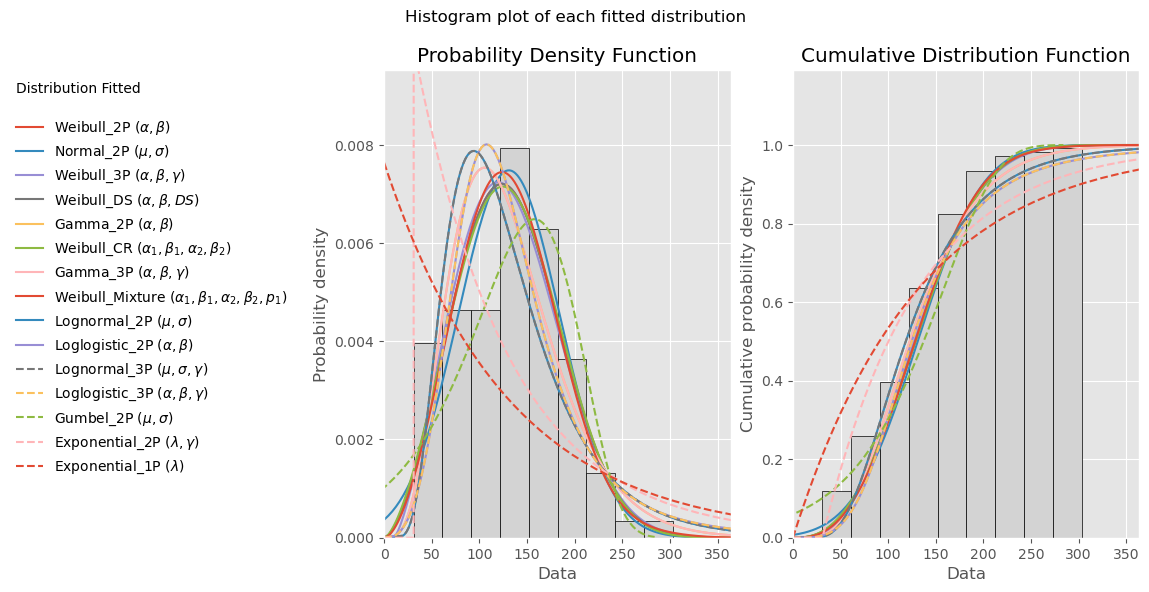

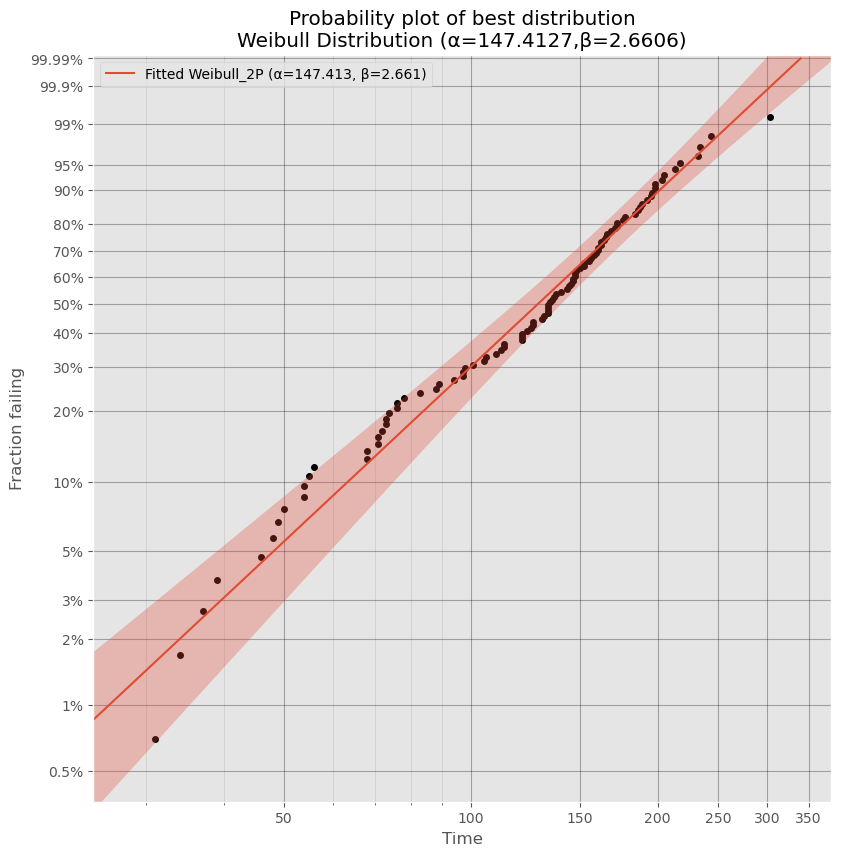

In [ ]:
from reliability.Fitters import Fit_Everything

# Fit the Weibull distribution to the last cycle data

output = Fit_Everything(failures=df_test_last_cycle.tolist(), 
               show_histogram_plot=True, 
               show_probability_plot=False, 
               show_PP_plot=False, 
               show_best_distribution_probability_plot=True,
               sort_by="BIC",)
plt.show()

Let's take the null hypothesis: $H_0$: The data follows a Weibull distribution with parameters $\alpha=147.4127,\beta=2.6606$ \
This means that the alternative hypothesis is: $H_a$: The data does not follow a Weibull distribution with parameters $\alpha=147.4127,\beta=2.6606$\
With a significance level of $\alpha=0.05$, we can use the chi-squared test to test the null hypothesis. As we can see in the code below, we can accept the null hypothesis.

Results from Chi-squared test:
Chi-squared statistic: 6.489281900130742
Chi-squared critical value: 12.591587243743977
At the 0.05 significance level, we can ACCEPT the hypothesis that the data comes from a weibull distribution (α=147.4127,β=2.6606)


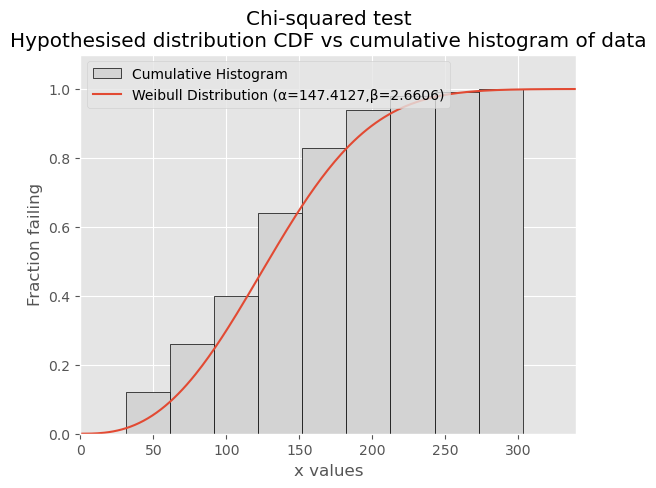

In [6]:
# test all distributions with the chi-square test
from reliability.Reliability_testing import chi2test

chi_test_results = chi2test(distribution=output.best_distribution,
                        data=df_test_last_cycle.tolist(),
                        significance=0.05,)


## Part 1.3
### Explain the parameters of the best fitted distribution(s). (2 points)
Answer: according to "Probability Distributions Used in Reliability Engineering" the Weibull distribution is defined by two parameters: $\alpha$ and $\beta$. The parameter $\alpha$ is the scale parameter, which equals the 63.2th percentile. The parameter $\beta$ is the shape parameter, which is also known as the slope

## Part 1.4
### Visualize and describe the shape of the hazard functions of the best fitted distribution(s). What does the shape tell you about the possible optimal maintenance strategy? (5 points)
Answer: Seeing the code and plot below, we see that the hazard function of the Weibull_2P distribution is increasing. So the derivative is positive. For this reason, the best maintenance strategy would be a preventive maintenance strategy. Then we would have to chose between age-replacement or block replacement. Given that we are only considering one component, and the difficulty of replacing the component is not considered, we would choose for age-replacement. 

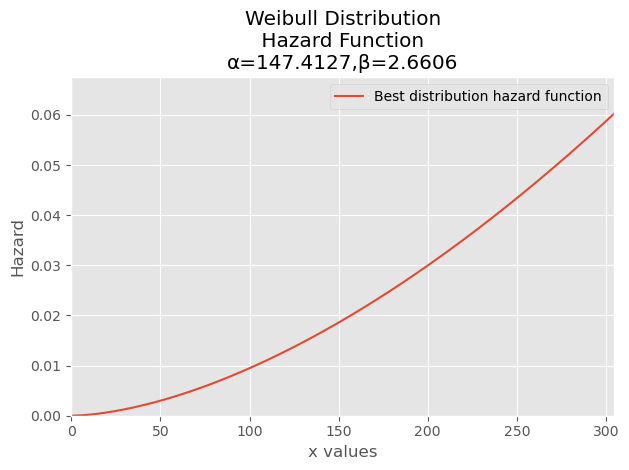

In [7]:
_ = output.best_distribution.HF(show_plot=True, label="Best distribution hazard function")
plt.legend()
plt.tight_layout()
plt.show()

## Part 1.5
### Calculate the optimal value of t and the corresponding long-term average maintenance costs g(t). Visualize your answer
Answer: See the code and plot below. The optimal value of t 53.51. expected long-term average maintenance costs g(t) is 302.06. 

Results from optimal_replacement_time:
Cost model assuming as good as new replacement (q=0):
The minimum cost per unit time is 302.06 
The optimal replacement time is 53.51


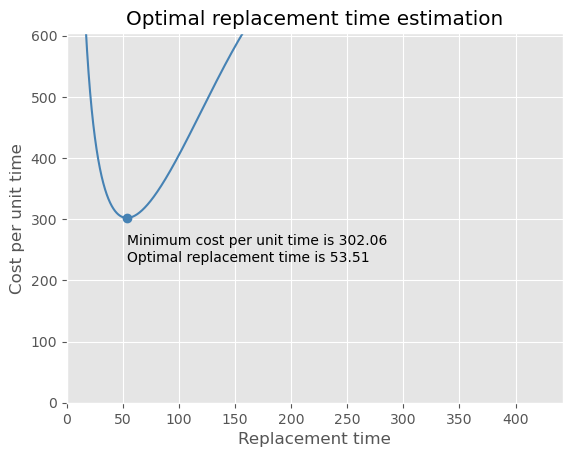

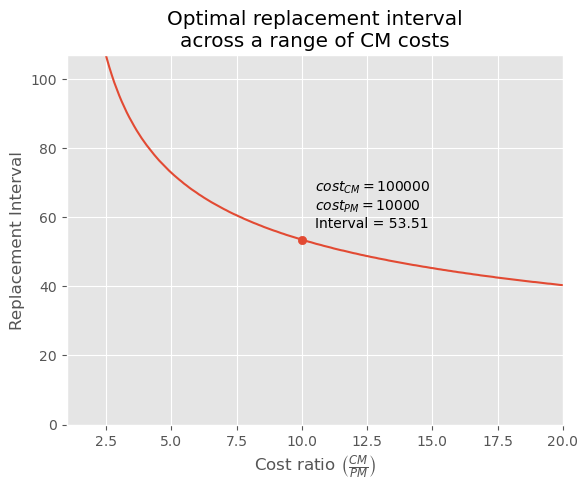

In [8]:
from reliability.Repairable_systems import optimal_replacement_time

t_optimal = optimal_replacement_time(cost_PM=PREVENTIVE_COST,
                                               cost_CM=CORRECTIVE_COST,
                                               weibull_alpha=output.best_distribution.alpha,
                                               weibull_beta=output.best_distribution.beta)